[View in Colaboratory](https://colab.research.google.com/github/iesilder/projectFinance/blob/master/Zipline%EA%B8%B0%EC%B4%88.ipynb)

In [1]:
# 라이브러리 설치
!pip install zipline

    100% |████████████████████████████████| 2.5MB 8.5MB/s 
    100% |████████████████████████████████| 92kB 18.4MB/s 
    100% |████████████████████████████████| 112kB 16.5MB/s 
    100% |████████████████████████████████| 3.4MB 5.7MB/s 
    100% |████████████████████████████████| 143kB 28.1MB/s 
    100% |████████████████████████████████| 112kB 14.3MB/s 
    100% |████████████████████████████████| 1.3MB 14.5MB/s 
    100% |████████████████████████████████| 163kB 27.3MB/s 
    100% |████████████████████████████████| 624kB 22.2MB/s 
    100% |████████████████████████████████| 71kB 18.4MB/s 
    100% |████████████████████████████████| 573kB 21.3MB/s 


    100% |████████████████████████████████| 5.6MB 5.3MB/s 
    100% |████████████████████████████████| 163kB 25.4MB/s 
    100% |████████████████████████████████| 51kB 16.7MB/s 
    100% |████████████████████████████████| 3.8MB 8.9MB/s 
    100% |████████████████████████████████| 61kB 16.9MB/s 
    100% |████████████████████████████████| 5.9MB 4.6MB/s 
  Running setup.py bdist_wheel for zipline ... - \ | / - \ | / - \

 | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/a4/d6/67/f303ab028b004bf8e00c05b5b04fba83d8ec238b6547becdb7
  Running setup.py bdist_wheel for Logbook ... - \ done
  Stored in directory: /content/.cache/pip/wheels/3a/50/0d/b67da0bb2a56061970cdf37a5e95fb07d9106200f33044616e
  Running setup.py bdist_wheel for cyordereddict ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/0b/9d/8b/5bf3e22c1edd59b50f11bb19dec9dfcfe5a479fc7ace02b61f
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /content/.

    Uninstalling networkx-2.1:
      Successfully uninstalled networkx-2.1


In [0]:
# 플롯 출력을 위해 강제로 backend를 바꾼다.
import matplotlib
# Force matplotlib to not use any Xwindows backend.
#matplotlib.use('Agg')
matplotlib.get_backend()
matplotlib.pyplot.switch_backend('Agg')

In [0]:
# 사용할 라이브러리 import
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [0]:
# html에 있는 정보를 읽어온다.
# 여기서 가져오는 정보는 종목 코드명이다.
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

In [10]:
# 데이터 타입 및 내용 확인
print(type(code_df))
print(code_df.head())

<class 'pandas.core.frame.DataFrame'>
     회사명   종목코드             업종                         주요제품         상장일  결산월  \
0     CJ   1040         기타 금융업                         지주회사  1973-06-29  12월   
1    HDC  12630         건물 건설업  토목공사,건축공사,아파트분양사업,재개발/재건축사업  1996-10-16  12월   
2  HSD엔진  82740  일반 목적용 기계 제조업               대형선박용엔진,내연발전엔진  2011-01-04  12월   
3  KG케미칼   1390    기초 화학물질 제조업    콘크리트혼화제, 비료, 친환경농자재, 수처리제  1989-08-25  12월   
4  LG이노텍  11070       전자부품 제조업                  기타 전자부품 제조업  2008-07-24  12월   

            대표자명                         홈페이지     지역  
0  손경식, 이재현, 이채욱            http://www.cj.net  서울특별시  
1            정몽규        http://www.i-park.com  서울특별시  
2            고영열  http://www.doosanengine.com   경상남도  
3            김경묵      http://www.kgchem.co.kr  울산광역시  
4            박종석   http://www.lginnotek.co.kr  서울특별시  


In [0]:
# 종목코드를 균일하게 000000자리로 맞추는 작업을 한다.
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [0]:
# 한글로 된 컬럼명을 영어로 바꾼다.
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})

In [0]:
# code_df에서 필요한 컬럼만 뽑아서 새로 code_df를 정의한다.
code_df = code_df[['name', 'code']]

In [0]:
# 특정 업체의 코드를 가져오기 위한 함수 정의
def get_url(item_name, code_df):
    # 코드를 가져오기 위한 처리.
    # 먼저 .query("name=='{}'".format(item_name))['code']는 name 컬럼에 item_name과 동일한 값의 code값을 반환한다는 뜻.
    # 즉, .query("쿼리".format(쿼리에 넣을 데이터))[얻을 자료]
    # .to_string(index = False)로 위에서 얻어진 값에 index를 빼고 string타입으로 바꿔준다.
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index = False)
    # url은 일일 종가 시가 고가 저가 거래량을 보여주는 표이다.
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code = code)
    print("요청 URL = {}".format(url))
    return url

In [15]:
# 데이터를 확인해본다.
code_df['name'][:20]

0          CJ
1         HDC
2       HSD엔진
3       KG케미칼
4       LG이노텍
5     SH에너지화학
6      SK네트웍스
7      STX중공업
8      WISCOM
9     갤럭시아에스엠
10     경동도시가스
11       고려제강
12    골든브릿지증권
13       극동유화
14     금호에이치티
15      까뮤이앤씨
16      노루페인트
17     녹십자홀딩스
18      대덕GDS
19     대림씨엔에스
Name: name, dtype: object

In [0]:
# code_df.name에서 "LG"가 들어간 데이터만 추출한다.
lg_list = []
for i in range(len(code_df['name'])):
  if "LG" in code_df['name'][i]:
    lg_list.append(code_df.loc[i].tolist())
# list = code_df.loc[code_df['name'].str.contains("LG")]  # 이렇게 해도 추출된다. 이후 처리 필요.

In [0]:
# 추출한 데이터를 데이터프레임으로 바꾼다.
lg_df = pd.DataFrame(lg_list, columns=['name', 'code'])

In [9]:
# 데이터 확인
lg_df

,name,code
0,LG이노텍,011070
1,LG디스플레이,034220
2,LG하우시스,108670
3,LG,003550
4,LG유플러스,032640
5,LG전자,066570
6,LG화학,051910
7,LG상사,001120
8,LG생활건강,051900


In [0]:
# 각 회사별 자료를 사전 타입에 저장을 한다.
# 2016~2017 자료를 train, 2018-01-01~2018-07-27까지의 자료를 test로 놓겠다.
lg_dict_train = {}  # 저장할 객체
lg_dict_test = {}
name_list = lg_df.name  # 이름
code_list = lg_df.code  # 코드
url = 'http://finance.naver.com/item/sise_day.nhn?code='


In [0]:
# 페이지 자료에 맞춰서 데이터를 구분한다.
# 시간이 오래 걸림
# test 데이터
for i in range(len(lg_df.name)):
    for page in range(1, 15):  # 1~14페이지까지 2018-01-01~2018-07-27 자료
        if page == 1:
            df = pd.DataFrame()
        pg_url = url + '{code}&page={page}'.format(code = code_list[i], 
                                                   page = page)  # url을 저장한다.
        # 데이터 프레임으로 만든다.
        df = df.append(pd.read_html(pg_url, header = 0)[0], ignore_index = True)
        if page == 14:  # 전처리 및 저장을 한다.
            df = df.rename(columns= {'날짜': 'date', '종가': 'close', 
             '전일비': 'diff', '시가': 'open', '고가': 'high', 
             '저가': 'low', '거래량': 'volume'})  # 컬럼명을 바꾼다.
            # 결측치 제거 및 오름차순으로 정렬한다.
            df = df.sort_values('date', ascending=True).dropna()
            lg_dict_test[name_list[i]] = df  # 데이터프레임을 key, value로 저장한다.

In [21]:
print(lg_dict_test[name_list[0]].head())  # 데이터 확인

           date     close     diff      open      high       low     volume
208  2018.01.04  145000.0   2000.0  148000.0  148500.0  144500.0   186790.0
207  2018.01.05  145500.0    500.0  146000.0  148000.0  143000.0   236799.0
206  2018.01.08  142000.0   3500.0  148000.0  148500.0  139500.0   471519.0
205  2018.01.09  156500.0  14500.0  153500.0  160500.0  149000.0  1239506.0
204  2018.01.10  149000.0   7500.0  157000.0  157500.0  147500.0   603263.0


In [0]:
# 페이지 자료에 맞춰서 데이터를 구분한다.
# 시간 오래 걸림.
# train 데이터
for i in range(len(lg_df.name)):
    for page in range(15, 64):  # 15~64페이지까지 2016~2017 자료
        if page == 15:
            df = pd.DataFrame()
        pg_url = url + '{code}&page={page}'.format(code = code_list[i], 
                                                   page = page)  # url을 저장한다.
        # 데이터 프레임으로 만든다.
        df = df.append(pd.read_html(pg_url, header = 0)[0], ignore_index = True)
        if page == 63:  # 전처리 및 저장을 한다.
            df = df.rename(columns= {'날짜': 'date', '종가': 'close', 
             '전일비': 'diff', '시가': 'open', '고가': 'high', 
             '저가': 'low', '거래량': 'volume'})  # 컬럼명을 바꾼다.
            # 결측치 제거 및 오름차순으로 정렬한다.
            df = df.sort_values('date', ascending=True).dropna()
            lg_dict_train[name_list[i]] = df  # 데이터프레임을 key, value로 저장한다.

In [23]:
lg_dict_train[name_list[0]].head()  # 데이터 확인

,date,close,diff,open,high,low,volume
733,2016.01.05,97500.0,2500.0,95500.0,97900.0,95300.0,197901.0
732,2016.01.06,92000.0,5500.0,97300.0,97300.0,89800.0,554241.0
731,2016.01.07,89200.0,2800.0,91400.0,92700.0,89000.0,320017.0
730,2016.01.08,90500.0,1300.0,88500.0,90500.0,87700.0,144996.0
729,2016.01.11,88200.0,2300.0,89700.0,89800.0,87800.0,108460.0


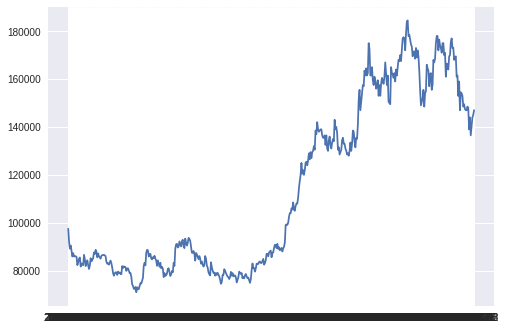

In [13]:
# 데이터 띄워보기
data = lg_dict_train[name_list[0]]
x = data.date.tolist()
y = data.close.tolist()
#print(type(a))
#print(data.columns.values)

plt.plot(x, y)

In [0]:
from zipline.api import order, symbol
from zipline.algorithm import TradingAlgorithm
from datetime import datetime

In [0]:
# 백테스팅 시뮬레이션
# initialize, handle_data 함수 만들기
def initialize(context):
  pass
def handle_data(context, data):
  order(symbol('close'), 1)  # context로 컬럼 선택, data로 매매 방법을 설정한다.
algorithm = TradingAlgorithm(initialize=initialize, handle_data=handle_data)

In [60]:
# 테스트를 위해 하나의 데이터 프레임만 가져와보기.
# tz_localize로 시간까지 표현하기
data = lg_dict_train[name_list[0]]
# 기존 str 데이터를 datetime으로 바꿔준다. 이걸해야지만 zipline이 돌아간다.
data['date'] = [datetime.strptime(i, "%Y.%m.%d") for i in data.date]
data = data.set_index('date')  # 기존 인덱스 0~ 을 date 컬럼을 이용하는 것으로 바꾼다.
data.head()  # 데이터 확인.
data = data.tz_localize("UTC")  # 시간을 맞춰준다.
data.head()  # 데이터 확인

TypeError: ignored

In [61]:
result = algorithm.run(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


AttributeError: ignored